<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using the Landlab SimpleSubmarineDiffuser component

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial demonstrates how to use the `SimpleSubmarineDiffuser` component. `SimpleSubmarineDiffuser` models submarine sediment transport using a diffusion approach, in which the diffusivity varies with water depth. The component sets diffusivity to a (nearly) constant value between sea level and the wave-base depth, and to a value that declines exponentially with depth below the wave base. (The diffusivity on land, meaning locations with an elevation above current sea level, is set to an arbitrarily tiny positive value).

## Theory

The mathematics behind `SimpleSubmarineDiffuser` are as follows. The component represents a discretized numerical solution to the PDE:

$$\frac{\partial \eta}{\partial t} = -\nabla \cdot \mathbf{q_s}$$

$$\mathbf{q_s} = -D(h) \nabla\eta$$

where $\eta$ is surface height, $t$ is time, $\mathbf{q_s}$ is volume sediment transport rate per unit width (in terms of bulk volume, i.e., it incorporates porosity), and $D(h)$ is the transport coefficient (a.k.a., diffusivity) that varies with local water depth $h$.

First we define the applied shallow-water diffusivity, $D_s$, in terms of the local water depth $h$ and tidal range $R_t$. If $R_t = 0$, then $D_s$ is uniform where $h \ge 0$ (i.e., underwater), and negligibly tiny elsewhere (i.e., on land). If $R_t > 0$, then a smoothing function is used to allow the applied diffusivity to increase smoothly from a negligibly small value on land (above ~2x high tide) to its base value, $D_{s0}$ (which is the input parameter `shallow_water_diffusivity`) below ~2x low-tide elevation:

$$D_s = (\tanh ( -h / R_t ) + 1) / 2$$

With this equation, $D_s \approx 0.02 D_{s0}$ at twice the high-tide height, and $D_s \approx 0.98 D_{s0}$ at twice the low-tide depth. The basic idea is to account in a simple way for tidal variations.

Within the wave zone, $D = D_s$ (which is to say, it is essentially constant except right around mean sea level). Below the wave-base depth, $h_{wb}$, the diffusivity decreases exponentially:

$$D = \begin{cases}
  D_s &\mbox{where } h > h_{wb} \\
  D_s \exp ( -(h - h_{wb}) / h_{wb} ) & \mbox{where } h \ge h_{wb} \end{cases}$$


## Numerical implementation

`SimpleSubmarineDiffuser` uses a forward-in-time, finite-volume method. It is the same method that the `LinearDiffuser` component uses, because in fact `SimpleSubmarineDiffuser` uses the solver of `LinearDiffuser`. The component is implemented as a class that derives directly from the `LinearDiffuser` class. The `run_one_step()` method of `SimpleSubmarineDiffuser` simply updates the current water depth (given sea level and topography), calculates the diffusivity coefficient, and then calls the `run_one_step()` method for the `LinearDiffuser` to perform the mass balance.

### Technical notes

- To avoid divide-by-zero errors, a tiny positive diffusivity (currently 10$^{-20}$ m$^2$/y) is assigned to nodes on land (or more precisely, added to any additional diffusivity that arises from the tanh function; see above).

- The component assigns diffusivity values to *nodes*, but the `LinearDiffuser` component then translates these to *links*. It maps diffusivity from nodes to links by using the *maximum* value of diffusivity of the nodes bounding each link. This means in practice that links that cross the shoreline will tend to have a higher diffusivity than the equations outlined above might suggest. In future, this could be addressed by modifying `LinearDiffuser` (which, however, could be a compatibility-breaking change unless handled as a user option), or by encoding the solver directly in `SimpleSubmarineDiffuser` as opposed to borrowing the solver of `LinearDiffuser`. 


## Examples

### Example 1: Quasi-1D

The first example uses a quasi-1D setup to represent an initial topography with a triangular cross-section. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.components import SimpleSubmarineDiffuser

In [2]:
grid = RasterModelGrid((3, 51)) # grid has just one row of core nodes

# Close top and bottom boundaries
grid.set_closed_boundaries_at_grid_edges(False, True, False, True)

# We're required to create a topographic__elevation field at nodes
z = grid.add_zeros('topographic__elevation', at='node')

# Here's our triangular island...
z[:] = (25.0 - np.abs(grid.x_of_node - 25.0)) - 15.0

# ...with a flat seabed at 5 m depth
z[z<-5.0] = -5.0

# We'll keep a copy of the starting elevation for later comparison
z0 = z.copy()

# And we'll create a field to track cumulative deposition
cum_depo = grid.add_zeros('cumulative_deposit__thickness', at='node')

Text(0, 0.5, 'Elevation (m)')

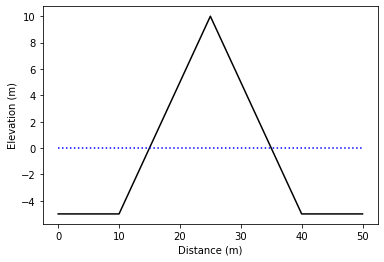

In [3]:
xm = grid.x_of_node[51:102]
zm = z[51:102]
plt.plot(xm, zm, 'k')
plt.plot([0, 50], [0, 0], 'b:') # add sea level
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')

In [4]:
# Instantiate the component
# (note 1 m2/y is a pretty small diffusivity; just for testing here)
ssd = SimpleSubmarineDiffuser(grid, sea_level=0.0,
                              wave_base=1.0,
                              shallow_water_diffusivity=1.0)

In [5]:
for i in range(500):
    ssd.run_one_step(0.2)
    cum_depo += grid.at_node['sediment_deposit__thickness']

Text(0, 0.5, 'Elevation (m)')

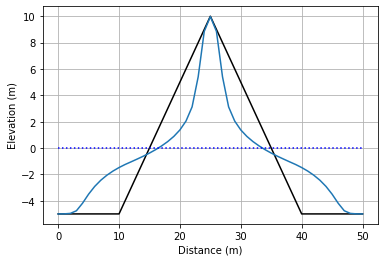

In [6]:
xm = grid.x_of_node[51:102]
zm = z[51:102]
plt.plot(xm, z0[51:102], 'k')
cum_depo[cum_depo < 0.0] = 0.0
plt.plot(xm, zm)
plt.plot([0, 50], [0, 0], 'b:')
plt.grid(True)
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')

(-5.0, 10.0)

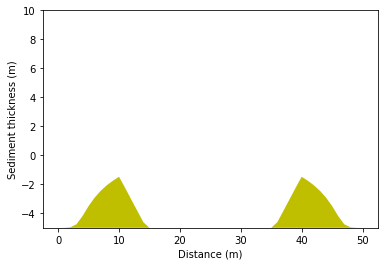

In [7]:
plt.fill(xm, cum_depo[51:102] - 5.0, 'y')
plt.xlabel('Distance (m)')
plt.ylabel('Sediment thickness (m)')
plt.ylim([-5, 10])

### Example 2: a conical island

The second example is much like the first, but now in 2D using a cone as the initial topography.

In [8]:
grid = RasterModelGrid((51, 51))
z = grid.add_zeros('topographic__elevation', at='node')
midpoint = 25.0

# Here we create the cone shape, again with a floor at 5 m depth
dx = np.abs(grid.x_of_node - midpoint)
dy = np.abs(grid.y_of_node - midpoint)
ds = np.sqrt(dx*dx + dy*dy)
z[:] = (midpoint - ds) - 15.0
z[z<-5.0] = -5.0

cum_depo = grid.add_zeros('total_deposit__thickness', at='node')

/opt/anaconda3/lib/python3.7/site-packages/landlab/plot/imshow.py:454: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  cmap.set_bad(color=color_for_closed)
/opt/anaconda3/lib/python3.7/site-packages/landlab/plot/imshow.py:494: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


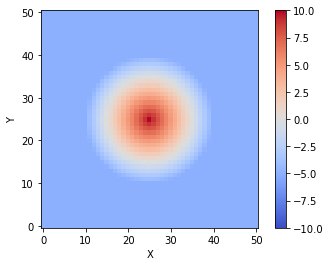

In [9]:
imshow_grid(grid, z, cmap='coolwarm', vmin=-10)

Text(0, 0.5, 'Elevation (m)')

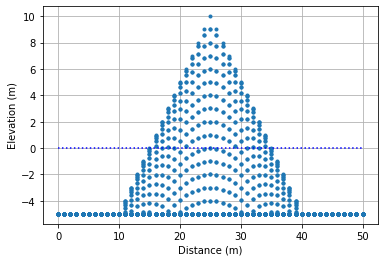

In [10]:
# Here's a pointillistic side view
plt.plot(grid.x_of_node, z, '.')
plt.plot([0, 50], [0, 0], 'b:')
plt.grid(True)
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')

In [11]:
ssd = SimpleSubmarineDiffuser(grid,
                              sea_level=0.0,
                              wave_base=1.0,
                              shallow_water_diffusivity=1.0)

In [12]:
for i in range(100):
    ssd.run_one_step(0.2)
    cum_depo += grid.at_node['sediment_deposit__thickness']

/opt/anaconda3/lib/python3.7/site-packages/landlab/plot/imshow.py:454: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  cmap.set_bad(color=color_for_closed)
/opt/anaconda3/lib/python3.7/site-packages/landlab/plot/imshow.py:494: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


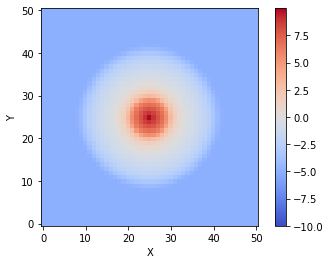

In [13]:
imshow_grid(grid, z, cmap="coolwarm", vmin=-10)

Text(0, 0.5, 'Elevation (m)')

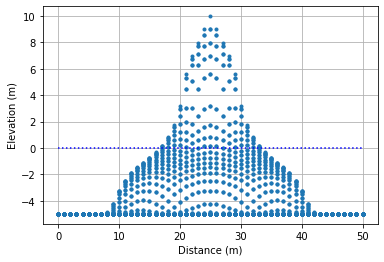

In [14]:
plt.plot(grid.x_of_node, z, '.')
plt.plot([0, 50], [0, 0], 'b:')
plt.grid(True)
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')

-1.47366563397e-11


/opt/anaconda3/lib/python3.7/site-packages/landlab/plot/imshow.py:454: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/opt/anaconda3/lib/python3.7/site-packages/landlab/plot/imshow.py:494: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


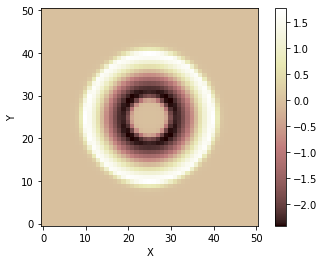

In [15]:
# Show the donut-shaped deposit and associated erosion pattern
imshow_grid(grid, cum_depo)

# And show that mass balances (the sum is basically zero, apart
# from a tiny roundoff error)
print(np.sum(cum_depo))

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>